In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['figure.figsize'] = (10, 8)

# Implicit Methods for ODEs

## Model stiff problem

Consider the ODE

$$\dot{y} = -10^3 (y - e^{-t}) - e^{-t}$$

with $y(0) = 0$.  This has the exact solution:

$$y(t) = e^{-t} - e^{-10^3 t}$$

We see that there are 2 characteristic timescales in the solution: $\tau_1 = 1$ and $\tau_2 = 10^{-3}$.  This is a
*stiff* ODE. 

(This example comes from Byrne and Hindmarsh 1986).

### Explicit discretization

Let's solve this using 4th order Runge-Kutta.

First we need the righthand side function:

In [8]:
def f(t, y):
    return -1.e3 * (y - np.exp(-t)) - np.exp(-t)

We'll also have a function that provides the analytic result, for comparison:

In [9]:
def analytic(t):
    return np.exp(-t) - np.exp(-1.e3*t)

Here's 4th order RK

In [10]:
def rk4(y0, dt, tmax):

    tsol = [0.0]
    ysol = [y0]

    t = 0.0
    y = y0

    while t < tmax:
        ydot1 = f(t, y)
        ydot2 = f(t+0.5*dt, y+0.5*dt*ydot1)
        ydot3 = f(t+0.5*dt, y+0.5*dt*ydot2)
        ydot4 = f(t+dt, y+dt*ydot3)

        y += (dt/6.0)*(ydot1 + 2.0*ydot2 + 2.0*ydot3 + ydot4)

        t += dt

        tsol.append(t)
        ysol.append(y)

    return np.asarray(tsol), np.asarray(ysol)

Let's make a function that can plot this.

In [28]:
def plot(t, y_numerical, label=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    tfine = np.linspace(0, t.max(), 1000)
    ax.plot(tfine, analytic(tfine), label="analytic")
    ax.plot(t, y, label=label)
    
    ax.set_xlabel("t")
    ax.set_ylabel("y")
    ax.legend(frameon=False)
    
    return fig

Now we can integrate it.  To start, let's pick a $\tau$ that is equal to the shortest timescale in the analytic solution.

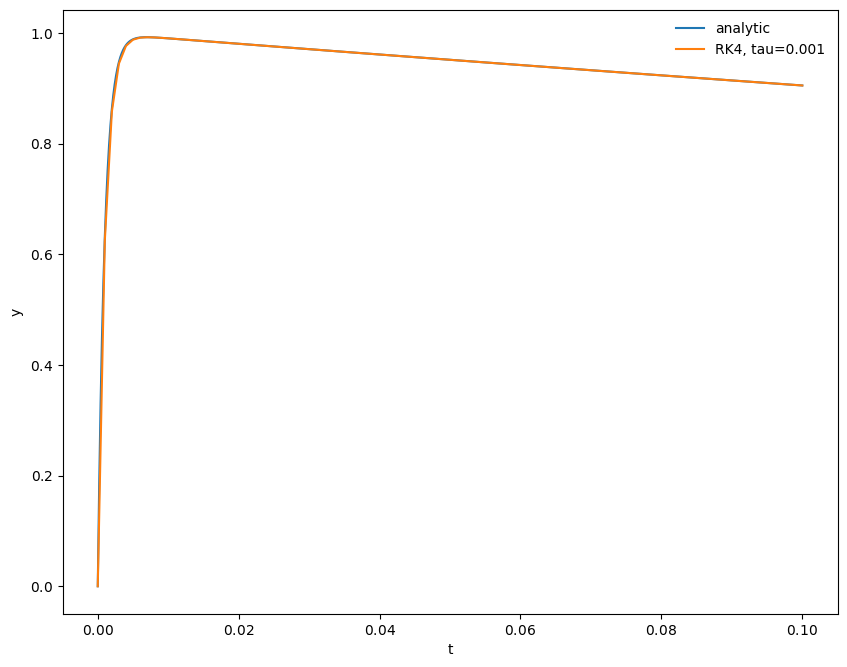

In [29]:
tau = 1.e-3
y0 = 0
tmax = 0.1

t, y = rk4(y0, tau, tmax)
fig = plot(t, y, label=f"RK4, tau={tau}")

We see that we do quite well -- the analytic solution and numerical solution are right on top of one another.

Now let's try some larger $\tau$s...

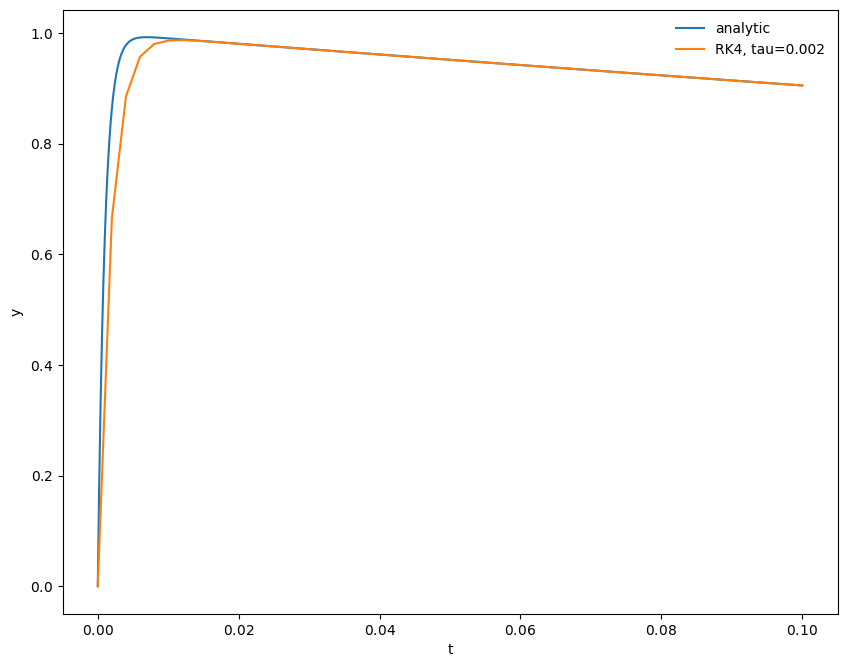

In [30]:
tau = 2.e-3
t, y = rk4(y0, tau, tmax)
fig = plot(t, y, label=f"RK4, tau={tau}")

For $\tau$ twice as big as the shortest timescale in the solution we do okay.  We miss the initial rise (because we are not resolving the short transient), but we get the longterm behavior correct.

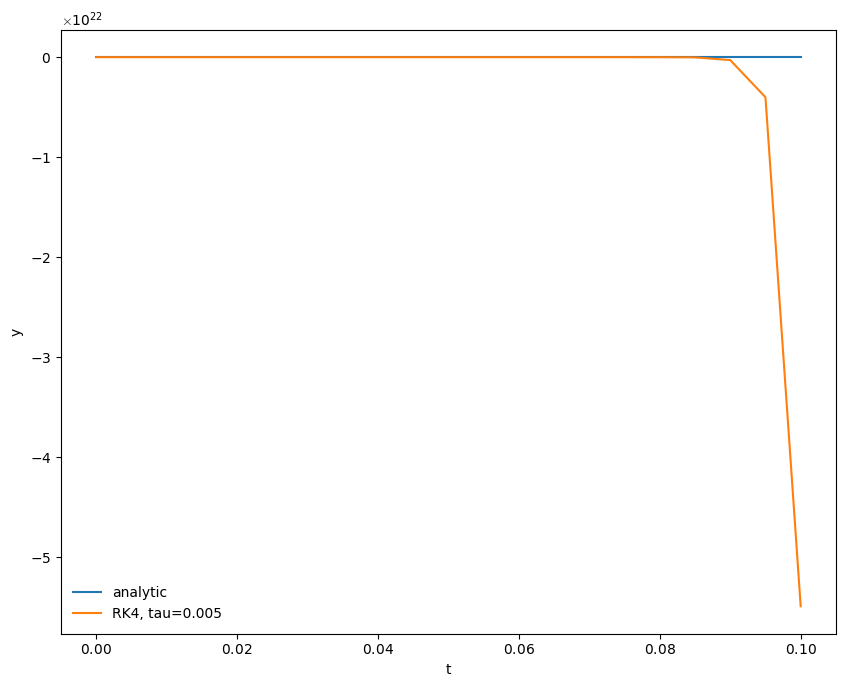

In [31]:
tau = 5.e-3
t, y = rk4(y0, tau, tmax)
fig = plot(t, y, label=f"RK4, tau={tau}")

For $\tau$ five times larger than the shortest timescale the solution blows up -- look at the vertical scale here.  

## Implicit discretization

Now let's try a simple first-order accurate implicit method

$$y^{n+1} = y^n + \tau \dot{y}^{n+1}$$

This is called *backward-Euler*.
For our model problem, we can solve for the new state algebraically:

$$y^{n+1} = \frac{y^n + 10^3 \tau e^{-t} - \tau e^{-t}}
 {1 + 10^3 \tau}$$
 
Notice that the solution doesn't blow up as we take $\tau \rightarrow \infty$.

In [32]:
def backward_euler(y0, dt, tmax):

    tsol = [0.0]
    ysol = [y0]

    t = 0.0
    y = y0

    while t < tmax:
        # an implicit discretication: y^{n+1} - y^n = dt ydot^{n+1}
        # and then solve analytically for y^{n+1}:
        ynew = (y + 1.e3*dt*np.exp(-t) - dt*np.exp(-t))/ (1.0 + 1.e3*dt)

        y = ynew
        t += dt

        tsol.append(t)
        ysol.append(y)

    return np.asarray(tsol), np.asarray(ysol)

let's try with the small and large timesteps we tried above:

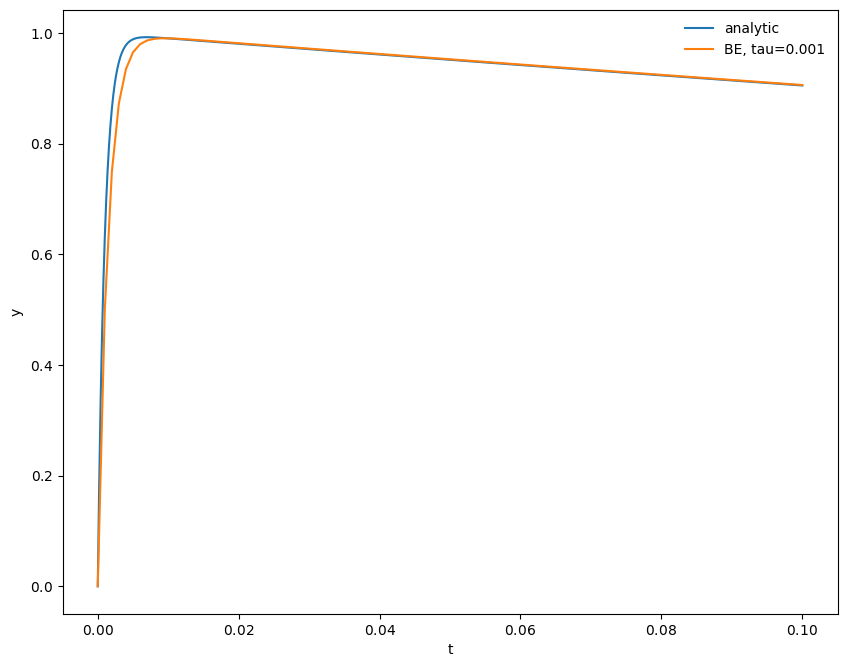

In [33]:
tau = 1.e-3
t, y = backward_euler(y0, tau, tmax)
fig = plot(t, y, label=f"BE, tau={tau}")

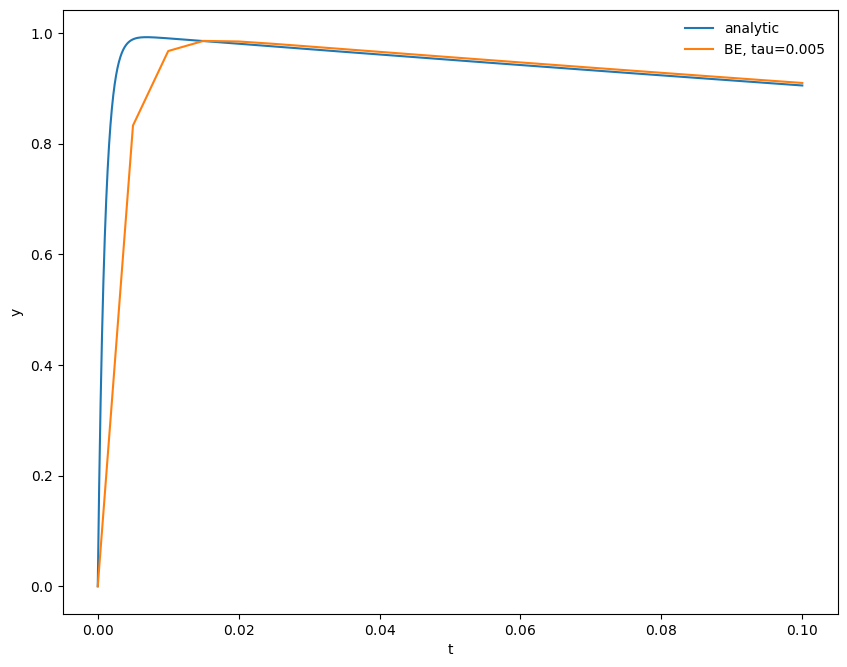

In [34]:
tau = 5.e-3
t, y = backward_euler(y0, tau, tmax)
fig = plot(t, y, label=f"BE, tau={tau}")

We see that the backward-Euler / implicit method remains stable even for $tau$ larger than the shortest timescale of change in the problem.